In [1]:
# import necessary libraries
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

## Introduction

__This is a predictive ML model development project for a mobile carrier (Megaline) to help assist their customers in picking one of their new coverage plans: "Smart" (0) or "Ultra" (1).  We will look at 3 possible classifier models and optimize each's hyperparameters to select the most accurate model. Using plan data that I have previously analyzed and processed, which includes call count, call minutes, messages, and megabytes used, we will split up indiviual training, validation, and test sets to train and test the chosen, optimized model. Each users data is classified by their plan. Choosing the most accurate option, the model must have a minimum accuracy threshold of at least 75%. Finally, we will evalute the model with a confusion matrix, and look at a classification report on the model's efficacy.__ 

In [2]:
# read in csv to dataframe
df = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
# get dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
# get dataframe shape
df.shape

(3214, 5)

In [5]:
# observe a random slice of the dataframe
df.sample(10)

,calls,minutes,messages,mb_used,is_ultra
1233,88.0,580.46,75.0,7325.36,1
177,110.0,801.62,37.0,5426.56,1
2306,54.0,366.17,59.0,19497.32,0
1980,47.0,367.09,42.0,22329.28,0
355,29.0,203.90,0.0,39969.14,1
1655,48.0,313.96,37.0,17915.92,0
2910,30.0,227.70,0.0,29555.11,1
591,60.0,419.02,21.0,11407.52,1
2081,76.0,535.01,20.0,12272.83,0
1806,62.0,364.31,0.0,13259.50,0


In [6]:
# define model features and target, where 0 = 'Smart' and 1 = 'Ultra'
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

## Split the data into train, validation, and test sets

Since we don't have a separate test set of data, I'll use a roughly 3:1:1 split ratio to split 75% of the data into the training set, with 20% each for both the validation and test sets.

In [7]:
# split the data into train(75%), test(20%), and validation(20%) sets. A 3:1:1 ratio for Train, Validation, and Test sets.
train_ratio = 0.75
test_ratio = 0.20
validation_ratio = 0.20
# training set
feature_train, feature_test, target_train, target_test = train_test_split(features, target, test_size=1-train_ratio, random_state=12345)
# test and validation sets
feature_valid, test_feature, target_valid, test_target = train_test_split(feature_test, target_test, test_size=test_ratio/(test_ratio+validation_ratio))
print(feature_train.shape)
print(target_train.shape)
print(feature_valid.shape)
print(target_valid.shape)
print(test_feature.shape)
print(test_target.shape)

(2410, 4)
(2410,)
(402, 4)
(402,)
(402, 4)
(402,)


## Tune model hyperparameters

Tuning the hyperparameters on the random forest, decision tree, and logistic regression models, using GridSearchCV to optimize and select the most accurate one.

In [54]:
# tune hyperparameters on random forest classifier
rfc = RandomForestClassifier(random_state=12345)
forest_params = [{'max_depth': list(range(1, 14)), 'max_features': ['auto', 'sqrt'], 'n_estimators': list(range(1, 50))}] # signify which hyperparameters to target
clf = GridSearchCV(rfc, forest_params, cv=10, scoring='accuracy')
clf.fit(feature_train, target_train)
print(clf.best_params_)
print(clf.best_score_)

{'max_depth': 9, 'max_features': 'auto', 'n_estimators': 34}
0.821161825726141


In [55]:
# tune hyperparameters on decision tree classifier
dtc = DecisionTreeClassifier(random_state=12345)
tree_params = [{'max_depth': list(range(1, 14)), 'criterion': ['entropy', 'gini']}] # signify which hyperparameters to target
clf_a = GridSearchCV(dtc, tree_params, cv=10, scoring='accuracy')
clf_a.fit(feature_train, target_train)
print(clf_a.best_params_)
print(clf_a.best_score_)

{'criterion': 'gini', 'max_depth': 9}
0.8004149377593361


In [56]:
# tune hyperparameters on logistic regression classifier
lrc = LogisticRegression(random_state=12345)
lr_params = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'penalty': ['none', 'elasticnet', 'l1', 'l2'], 'C': [0.01, 0.05, 0.10, 0.50, 0.75, 1.00]}] # signify which hyperparameters to target
clf_b = GridSearchCV(lrc, lr_params, cv=10, scoring='accuracy')
clf_b.fit(feature_train, target_train)
print(clf_b.best_params_)
print(clf_b.best_score_)

{'C': 0.01, 'penalty': 'none', 'solver': 'newton-cg'}
0.74149377593361


## Train and test the final model
Based on the above accuracy scores, I'm choosing to incorporate an optimized random forest classifier model to help predict the right plan for individual megaline customers as it has the highest accuracy at 82%. The random forest classifier incorporates an ensemble of trees rather than just one, and it minimizes the possiblity of overfitting.

In [9]:
# run the test features through the final, optimized random forest classifier model to analyze accuracy
final_model = RandomForestClassifier(random_state=12345, max_depth=9, max_features='auto', n_estimators=34)
final_model.fit(feature_train, target_train)
train_predictions = final_model.predict(feature_train)
test_predictions = final_model.predict(test_feature)

## Get accuracy score

Calculate and compare the accuracy scores for both the training and test data sets.  The training set accuracy comes out at about 88%. Given the test set accuracy is at 81%, well above the 75% threshold for this model's development, we can move forward with evaluating the model.

In [10]:
# test the accuracy of the train set
train_accuracy = accuracy_score(target_train, train_predictions)
print("Training set accuracy:", train_accuracy)

Training set accuracy: 0.8771784232365145


In [11]:
# test the accuracy of the test set
test_accuracy = accuracy_score(test_target, test_predictions)
print("Test set accuracy:", test_accuracy)

Test set accuracy: 0.8109452736318408


## Evaluate the model

Using a confusion matrix in conjuction with a classification report, we will evalute the model's error percentage, as well as it's precision and recall.  The values on the diagonal axis (top left to bottom right) of the the matrix show the number of times the model predicted correctly vs the times it didn't.  Precision is equated to the number of times the model predicted the coverage plan correctly divided by the total number of times the model selected the coverage plan overall, correctly or incorrectly.  The recall equates to the number of each plan the model predicted correctly divided by the total number of members that plan.

In [19]:
# evaluate the random forest model with a confusion matrix
matrix = confusion_matrix(test_target, test_predictions)
print(matrix)

[[253  16]
 [ 60  73]]


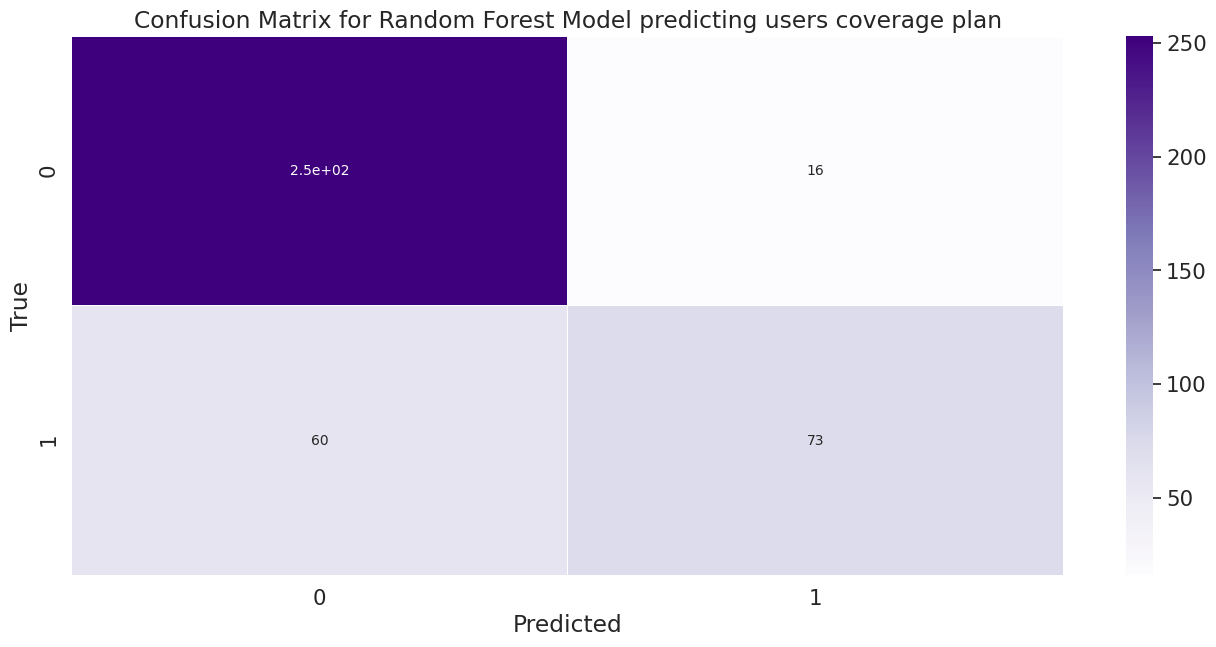

In [24]:
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap='Purples', linewidths=0.2)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Random Forest Model predicting users coverage plan')
plt.show()

In [16]:
# print a classification report on the random forest model test set and predictions
print(classification_report(test_target, test_predictions))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87       269
           1       0.82      0.55      0.66       133

    accuracy                           0.81       402
   macro avg       0.81      0.74      0.76       402
weighted avg       0.81      0.81      0.80       402



## Conclusion
Overall, our random forest final model's accuracy was 81% in predicting the correct coverage plan for each Megaline customer.  It chose the "Smart" plan correctly 253 times and the "Ultra" plan correctly 73 times. The precision score of our model in reference to each plan was 81% for "Smart" and 82% for "Ultra", which means the model was pretty good at not matching plans incorrectly.  However, the recall score for the "Ultra" plans was relatively low, meaning that the model may be misidentifying the "Ultra" plans because it's being too careful in it's classification. The F1 score reflects this imbalance at 66%, as it's a combination of both the precision and recall scores.  Overall, the model, while not perfect, performs well above the overall accuracy threshold of 75% and can be used to predict users' new coverage plans to an above 80% precision.  Combining more data with perhaps more features to the training and test sets when available, will help to improve this models classification accuracy and overall efficacy in pridicting plans for users moving forward.